<a href="https://colab.research.google.com/github/sgencer2001/shelfgapdetection/blob/main/gapdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p "/content/drive/GapDetectionProject

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16567, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 16567 (delta 23), reused 31 (delta 13), pack-reused 16522
Receiving objects: 100% (16567/16567), 15.08 MiB | 23.91 MiB/s, done.
Resolving deltas: 100% (11380/11380), done.
/content/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.7 MB/s eta 0:00:00
ERROR: Operation cancelled by user


KeyboardInterrupt: 

In [ ]:
!pip install roboflow
%cd content
from roboflow import Roboflow
rf = Roboflow(api_key="iytEkhHjy0b3Dr0gqAuZ")
project = rf.workspace("shelfgapdetection").project("shelfgapdetection_racks")
version = project.version(2)
dataset = version.download("yolov5")


In [ ]:
%cd /content/yolov5/ShelfGapDetection_Racks-2/

In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [ ]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [12]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 640 --batch 16 --epochs 30 --data ShelfGapDetection_Racks-2/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

[Errno 2] No such file or directory: '/content/yolov5/'
/content
python3: can't open file '/content/train.py': [Errno 2] No such file or directory
CPU times: user 3.69 ms, sys: 2.6 ms, total: 6.3 ms
Wall time: 106 ms


Save yolov5 trained weights as .pt file in Google Drive

In [ ]:

%cd content/yolov5/runs/train/yolov5s_results
%cd weights
%ls

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/My\ Drive
%cp /content/yolov5/runs/train/yolov5s_results/weights/last.pt /content/gdrive/My\ Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%cp -r /content/yolov5 /content/gdrive/My\ Drive

# Evaluate Custom YOLOv5 Detector Performance

You can view the training graphs associated with a training job in the `/content/yolov5/runs/train/yolov5s_results/results.png` folder.

Training losses and performance metrics are also saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [11]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

ModuleNotFoundError: No module named 'utils'

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

# Run Inference With Trained Weights

Next, we can run inference with a pretrained checkpoint on all images in the `test/images` folder to understand how our model performs on our test set.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

In [ ]:
%ls runs/train/yolov5s_results/weights

In the snippet below, replace `Cash-Counter-10` with the name of the folder in which your dataset is stored.

In [ ]:
%cd /content/yolov5/
%cd ShelfGapDetection_Racks-2/
%cd test
%cd images
%ls

In [ ]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 640 --conf 0.4 --source ShelfGapDetection_Racks-2/test/images/

In [5]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp1/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))

## Deploy Model on Roboflow

Once you have finished training your YOLOv5 model, you’ll have a set of trained weights ready for use. These weights will be in the `/content/yolov5/runs/train/yolov5s_results/` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv5 weights.

**Before you run this code, make sure you create a new Version in the Roboflow dashboard following the instructions we covered earlier. Fill in your project name, workspace, and version number below.**

To upload model weights, add the following code to the “Inference with Custom Model” section in the aforementioned notebook:

In [ ]:
rf = Roboflow(api_key="iytEkhHjy0b3Dr0gqAuZ")
project = rf.workspace("shelfgapdetection").project("shelfgapdetection_racks")
version = project.version(3)
dataset = version.download("yolov5")

In [ ]:
#Run inference on your model on a persistant, auto-scaling, cloud API

#load model
model = project.version(dataset.version).model

#choose random test set image
import os, random
test_set_loc = dataset.location + "/test/images/"
random_test_image = random.choice(os.listdir(test_set_loc))
print("running inference on " + random_test_image)



  












  
---





---



---



---



After the termination, since the model is gone, the model was exported for further use. Here we import the model through the Google Drive.

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive')

In [ ]:
%cd yolov5
%ls

In [ ]:
%ls runs/train/yolov5s_results/weights

In [ ]:
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 640 --conf 0.4 --source ShelfGapDetection_Racks-2/test/images/

In [20]:
%cd /content/drive/MyDrive/yolov5
%ls


[Errno 2] No such file or directory: '/content/drive/MyDrive/yolov5'
/content
sample_data/  yolov5/


In [16]:
%cd runs/detect
%ls

[Errno 2] No such file or directory: 'runs/detect'
/content/drive/MyDrive/yolov5/shelves/input
test10.jpg  test1.jpg  test3.jpg  test5.jpg  test7.jpg  test9.jpg
test11.jpg  test2.jpg  test4.jpg  test6.jpg  test8.jpg  test_extra_1.jpg


In [5]:
import glob
from IPython.display import Image, display

# Use an absolute path to locate the images
for imageName in glob.glob('/content/drive/MyDrive/yolov5/runs/detect/exp10/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))



---



---



---



---



---



Hyperparametern tuning and improval of the model



In [19]:
%ls

sample_data/  yolov5/


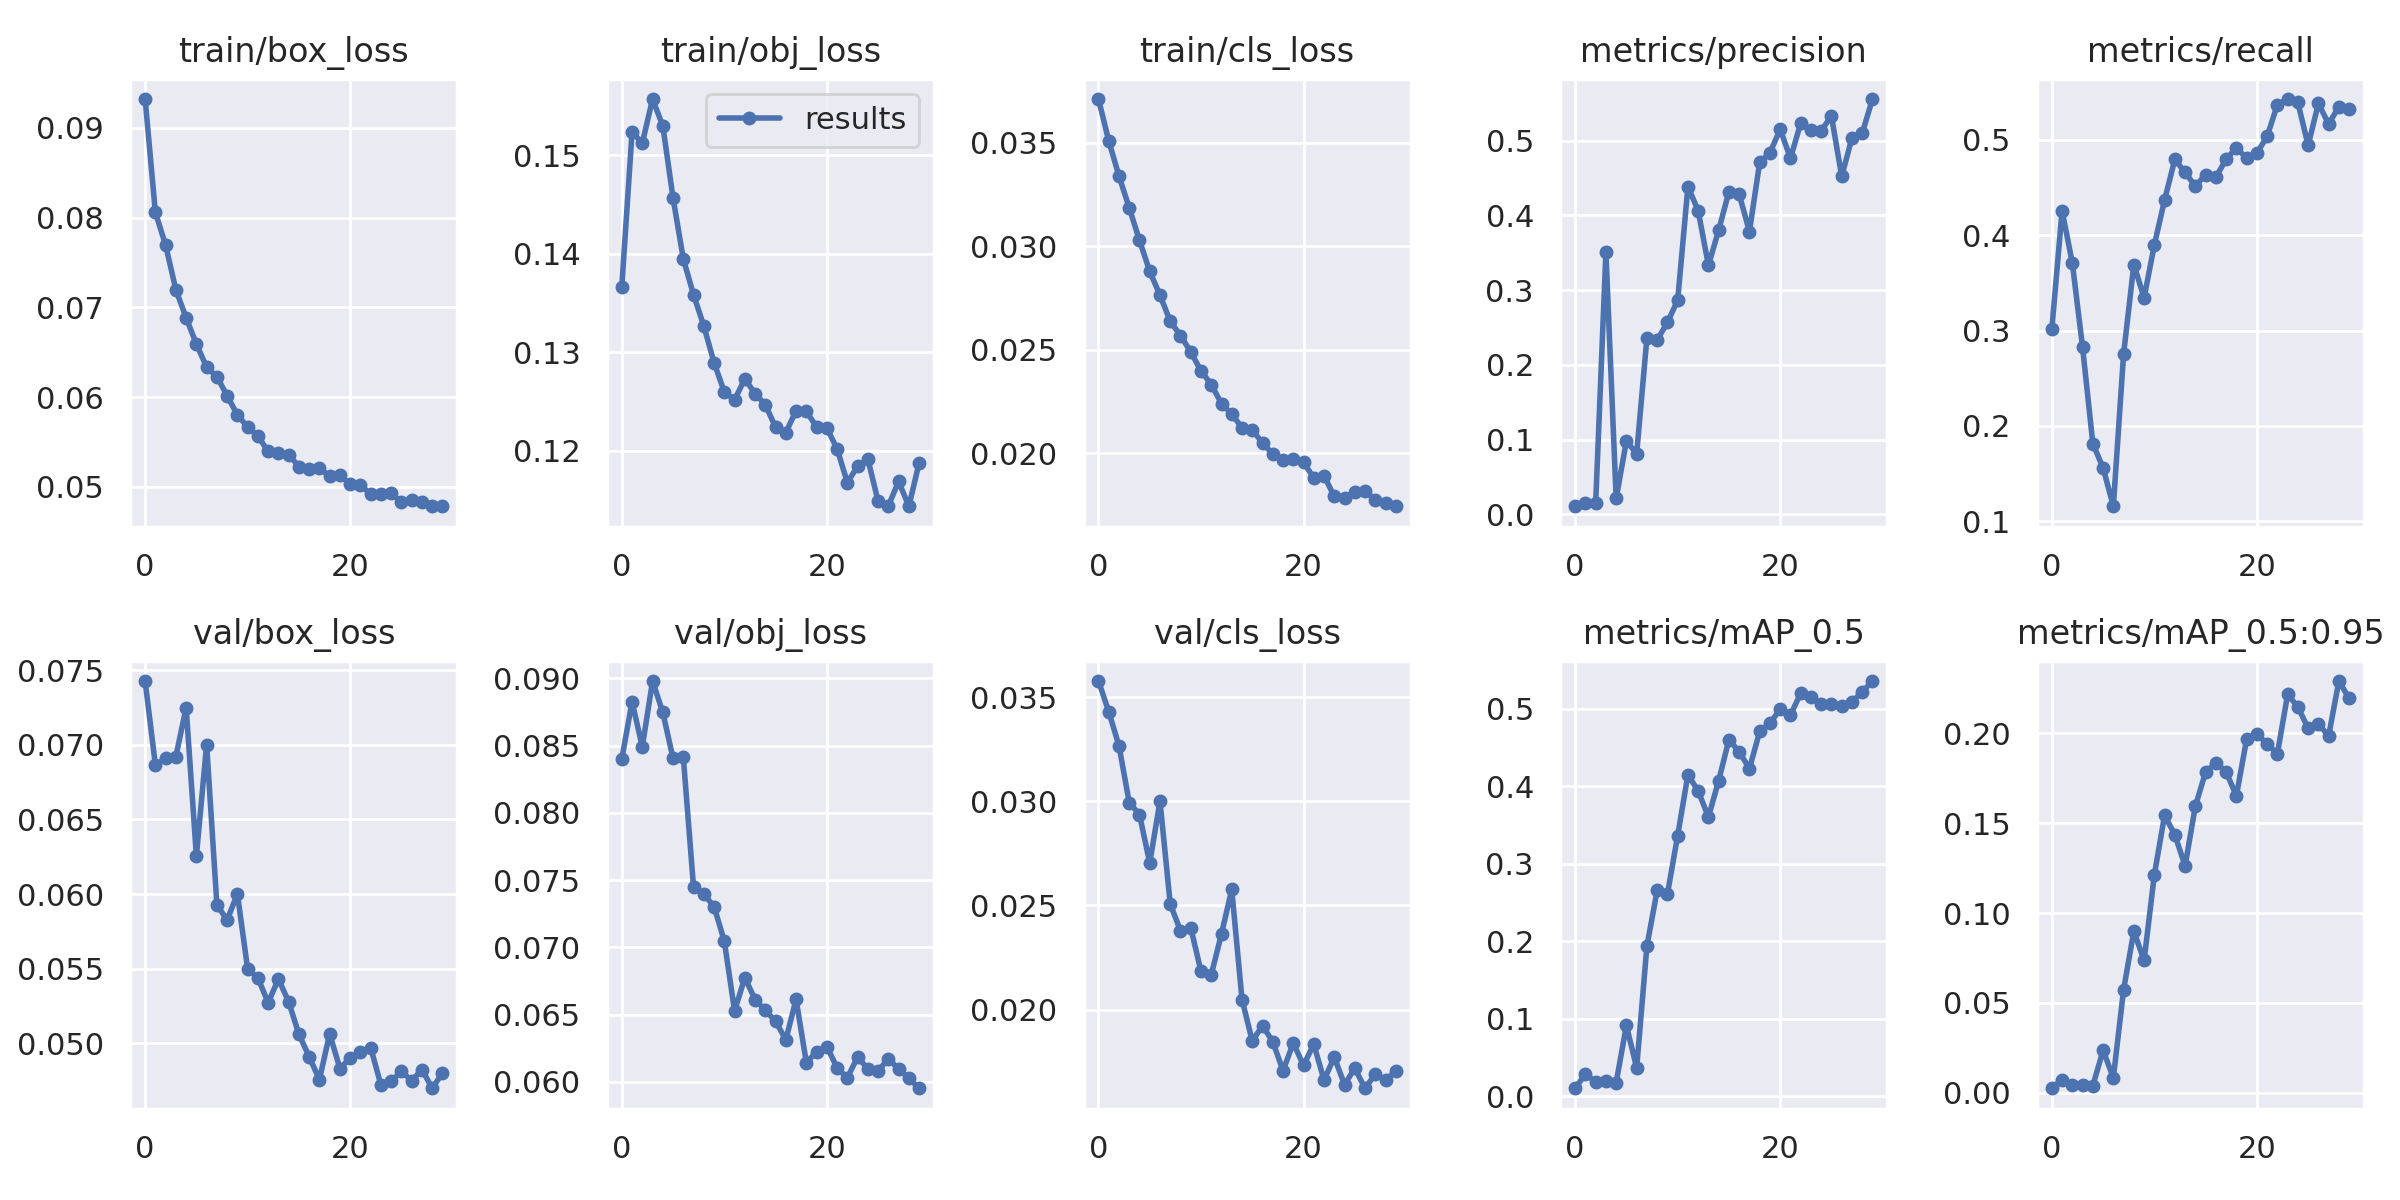

In [22]:
import glob
from IPython.display import Image, display


display(Image(filename='/content/drive/MyDrive/yolov5/runs/train/yolov5s_results/results.png', width=1000))
 # view results.png

# Object Detection Metrics
Let’s start by discussing some metrics that are not only important to YOLOv8 but are broadly applicable across different object detection models.

**Intersection over Union (IoU):** IoU is a measure that quantifies the overlap between a predicted bounding box and a ground truth bounding box. It plays a fundamental role in evaluating the accuracy of object localization.

**Average Precision (AP): **AP computes the area under the precision-recall curve, providing a single value that encapsulates the model's precision and recall performance.

**Mean Average Precision (mAP):** mAP extends the concept of AP by calculating the average AP values across multiple object classes. This is useful in multi-class object detection scenarios to provide a comprehensive evaluation of the model's performance.

**Precision and Recall:** Precision quantifies the proportion of true positives among all positive predictions, assessing the model's capability to avoid false positives. On the other hand, Recall calculates the proportion of true positives among all actual positives, measuring the model's ability to detect all instances of a class.

**F1 Score:** The F1 Score is the harmonic mean of precision and recall, providing a balanced assessment of a model's performance while considering both false positives and false negatives.

#How to Calculate Metrics for YOLOv8 Model
Now, we can explore YOLOv8's Validation mode that can be used to compute the above discussed evaluation metrics.

Using the validation mode is simple. Once you have a trained model, you can invoke the model.val() function. This function will then process the validation dataset and return a variety of performance metrics. But what do these metrics mean? And how should you interpret them?

Interpreting the Output
Let's break down the output of the model.val() function and understand each segment of the output.

Class-wise Metrics
One of the sections of the output is the class-wise breakdown of performance metrics. This granular information is useful when you are trying to understand how well the model is doing for each specific class, especially in datasets with a diverse range of object categories. For each class in the dataset the following is provided:

Class: This denotes the name of the object class, such as "person", "car", or "dog".

Images: This metric tells you the number of images in the validation set that contain the object class.

Instances: This provides the count of how many times the class appears across all images in the validation set.

Box(P, R, mAP50, mAP50-95): This metric provides insights into the model's performance in detecting objects:

P (Precision): The accuracy of the detected objects, indicating how many detections were correct.

R (Recall): The ability of the model to identify all instances of objects in the images.

mAP50: Mean average precision calculated at an intersection over union (IoU) threshold of 0.50. It's a measure of the model's accuracy considering only the "easy" detections.

mAP50-95: The average of the mean average precision calculated at varying IoU thresholds, ranging from 0.50 to 0.95. It gives a comprehensive view of the model's performance across different levels of detection difficulty.



Speed Metrics
The speed of inference can be as critical as accuracy, especially in real-time object detection scenarios. This section breaks down the time taken for various stages of the validation process, from preprocessing to post-processing.

COCO Metrics Evaluation
For users validating on the COCO dataset, additional metrics are calculated using the COCO evaluation script. These metrics give insights into precision and recall at different IoU thresholds and for objects of different sizes.

Visual Outputs
The model.val() function, apart from producing numeric metrics, also yields visual outputs that can provide a more intuitive understanding of the model's performance. Here's a breakdown of the visual outputs you can expect:

F1 Score Curve (F1_curve.png): This curve represents the F1 score across various thresholds. Interpreting this curve can offer insights into the model's balance between false positives and false negatives over different thresholds.

Precision-Recall Curve (PR_curve.png): An integral visualization for any classification problem, this curve showcases the trade-offs between precision and recall at varied thresholds. It becomes especially significant when dealing with imbalanced classes.

Precision Curve (P_curve.png): A graphical representation of precision values at different thresholds. This curve helps in understanding how precision varies as the threshold changes.

Recall Curve (R_curve.png): Correspondingly, this graph illustrates how the recall values change across different thresholds.

Confusion Matrix (confusion_matrix.png): The confusion matrix provides a detailed view of the outcomes, showcasing the counts of true positives, true negatives, false positives, and false negatives for each class.

Normalized Confusion Matrix (confusion_matrix_normalized.png): This visualization is a normalized version of the confusion matrix. It represents the data in proportions rather than raw counts. This format makes it simpler to compare the performance across classes.

Validation Batch Labels (val_batchX_labels.jpg): These images depict the ground truth labels for distinct batches from the validation dataset. They provide a clear picture of what the objects are and their respective locations as per the dataset.

Validation Batch Predictions (val_batchX_pred.jpg): Contrasting the label images, these visuals display the predictions made by the YOLOv8 model for the respective batches. By comparing these to the label images, you can easily assess how well the model detects and classifies objects visually.

Results Storage
For future reference, the results are saved to a directory, typically named runs/detect/val.

**Choosing the Right Metrics**
Choosing the right metrics to evaluate often depends on the specific application.

*mAP: Suitable for a broad assessment of model performance.*

*IoU: Essential when precise object location is crucial.*

*Precision: Important when minimizing false detections is a priority.*

*Recall: Vital when it's important to detect every instance of an object.*

*F1 Score: Useful when a balance between precision and recall is needed.*

For real-time applications, speed metrics like FPS (Frames Per Second) and latency are crucial to ensure timely results.

Interpretation of Results
It’s important to understand the metrics. Here's what some of the commonly observed lower scores might suggest:

Low mAP: Indicates the model may need general refinements.

Low IoU: The model might be struggling to pinpoint objects accurately. Different bounding box methods could help.

Low Precision: The model may be detecting too many non-existent objects. Adjusting confidence thresholds might reduce this.

Low Recall: The model could be missing real objects. Improving feature extraction or using more data might help.

Imbalanced F1 Score: There's a disparity between precision and recall.

Class-specific AP: Low scores here can highlight classes the model struggles with.

Case Studies
Real-world examples can help clarify how these metrics work in practice.

Case 1
Situation: mAP and F1 Score are suboptimal, but while Recall is good, Precision isn't.

Interpretation & Action: There might be too many incorrect detections. Tightening confidence thresholds could reduce these, though it might also slightly decrease recall.

Case 2
Situation: mAP and Recall are acceptable, but IoU is lacking.

Interpretation & Action: The model detects objects well but might not be localizing them precisely. Refining bounding box predictions might help.

Case 3
Situation: Some classes have a much lower AP than others, even with a decent overall mAP.

Interpretation & Action: These classes might be more challenging for the model. Using more data for these classes or adjusting class weights during training could be beneficial.

Connect and Collaborate
Tapping into a community of enthusiasts and experts can amplify your journey with YOLOv8. Here are some avenues that can facilitate learning, troubleshooting, and networking.

Engage with the Broader Community
GitHub Issues: The YOLOv8 repository on GitHub has an Issues tab where you can ask questions, report bugs, and suggest new features. The community and maintainers are active here, and it’s a great place to get help with specific problems.

Ultralytics Discord Server: Ultralytics has a Discord server where you can interact with other users and the developers.

Official Documentation and Resources:
Ultralytics YOLOv8 Docs: The official documentation provides a comprehensive overview of YOLOv8, along with guides on installation, usage, and troubleshooting.
Using these resources will not only guide you through any challenges but also keep you updated with the latest trends and best practices in the YOLOv8 community.

Conclusion
In this guide, we've taken a close look at the essential performance metrics for YOLOv8. These metrics are key to understanding how well a model is performing and are vital for anyone aiming to fine-tune their models. They offer the necessary insights for improvements and to make sure the model works effectively in real-life situations.

Remember, the YOLOv8 and Ultralytics community is an invaluable asset. Engaging with fellow developers and experts can open doors to insights and solutions not found in standard documentation. As you journey through object detection, keep the spirit of learning alive, experiment with new strategies, and share your findings. By doing so, you contribute to the community's collective wisdom and ensure its growth.

Happy object detecting!



In [ ]:
%cd /content/drive/MyDrive/yolov5
%ls
%cd ShelfGapDetection_Racks-2/
%ls


In [13]:
!git clone https://github.com/ultralytics/yolov5  # clone repo

Cloning into 'yolov5'...
remote: Enumerating objects: 16623, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 16623 (delta 56), reused 62 (delta 29), pack-reused 16522
Receiving objects: 100% (16623/16623), 15.10 MiB | 20.64 MiB/s, done.
Resolving deltas: 100% (11415/11415), done.


In [ ]:
%cd /content/drive
%cd MyDrive
%cd yolov5
#%cd models
%ls

In [ ]:
!python train.py --epochs 10 --data data.yaml --weights yolov5s.pt --cache --evolve




---



---



---



---



---



---



# * here starts the application

In [12]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
%cd /content/drive
%cd MyDrive
%cd yolov5
#%cd models
%ls
%cd shelves
%cd input
from google.colab import drive
drive.mount('/content/drive')
%ls

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/yolov5
benchmarks.py    export.py     README.zh-CN.md             ShelfGapDetection_Racks-4/  val.py
CITATION.cff     hubconf.py    requirements.txt            shelves/                    yolov5s.pt
classify/        LICENSE       runs/                       train.py
CONTRIBUTING.md  models/       segment/                    tutorial.ipynb
data/            __pycache__/  setup.cfg                   ultralytics/
detect.py        README.md     ShelfGapDetection_Racks-2/  utils/
/content/drive/MyDrive/yolov5/shelves
/content/drive/MyDrive/yolov5/shelves/input
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
test10.jpg  test1.jpg  test3.jpg  test5.jpg  test7.jpg  test9.jpg
test11.jpg  test2.jpg  test4.jpg  test6.jpg  test8.jpg  test_extra_1.jpg


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


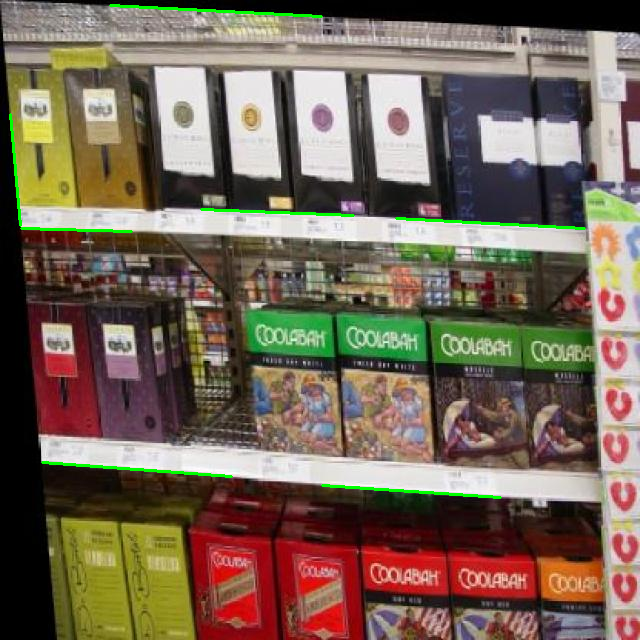

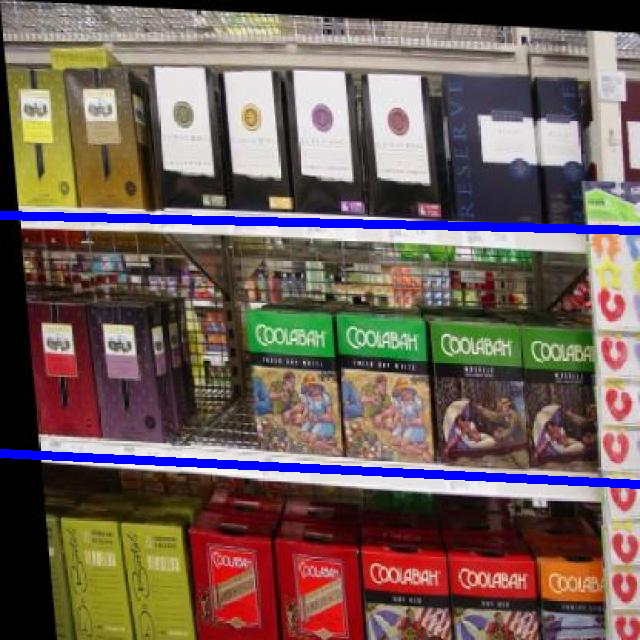

<class 'list'>
[[[0, 215, 640, 230]], [[0, 453, 640, 484]]]
[[[0, 0, 640, 0]], [[0, 215, 640, 230]], [[0, 453, 640, 484]], [[0, 640, 640, 640]]]


In [2]:

from google.colab import drive
drive.mount('/content/drive')

import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import os


def detect_shelves(image_path, save_dir, angle_threshold_degrees, line_thickness,
                   filter_min_vertical_distance_threshold, filter_max_vertical_distance_threshold, edge_ignore_threshold):
    # Step 1: Preprocess the Image
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred_image =cv2.bilateralFilter(gray_image, d=9, sigmaColor=75, sigmaSpace=120)


    image_height, image_width = image.shape[:2]


    #image_blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Step 2: Detect Edges
    edges = cv2.Canny(blurred_image,300,400, apertureSize=3)

    # Step 3: Detect Lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=20)
    # Create a copy of the original image to draw theoretical lines
    debug_image = image.copy()

    # Draw all detected lines on the debug image for inspection
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(debug_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Show the image with all theoretical lines
    cv2_imshow(debug_image)



    manipulated_lines = manipulate_lines(lines,
                                   angle_threshold_degrees,
                                   filter_min_vertical_distance_threshold,
                                   filter_max_vertical_distance_threshold,
                                   image_height,
                                   image_width,
                                   edge_ignore_threshold
                                   )
#lines, angle_threshold_degrees,filter_min_vertical_distance, image_height, image_width, edge_ignore_threshold
        # Step 7: Draw Lines
    for manipulated_line in manipulated_lines:
            x1, y1, x2, y2 = manipulated_line[0]
            cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), thickness=line_thickness)



    # Step 8: Display and Save Image
    cv2_imshow(image)
    #output_path = os.path.join(save_dir, 'detected_shelves.jpg')
    #cv2.imwrite(output_path, image)
    print(type(manipulated_lines))
    print(manipulated_lines)

    segment_shelves_and_normalize_images(image_path,manipulated_lines, save_dir)



def segment_shelves_and_normalize_images(image_path ,manipulated_lines, save_dir):
  #image = cv2.imread(image_path)
  image = cv2.imread(image_path)
  image_height,image_width= image.shape[:2]
  image_name = os.path.splitext(os.path.basename(image_path))[0]
  #print(image_name)
  save_dir = os.path.join(save_dir, image_name)
  if not os.path.exists(save_dir):
        os.makedirs(save_dir)





  #since there is no line that refers to the top area of the image, we should insert it to the list.
  manipulated_lines.insert(0,[[0, 0, image_width, 0]])
    # Assuming manipulated_lines is a list of lists containing the coordinates of each line.
    # Sort lines by the average y position (top to bottom)
    # Add the bottom of the image as the end point for the last segment
    #if the last coordinate of the manipulated line is not equal to the image bottom coordination
    #add a virtual downmost line
  if manipulated_lines[-1][0][3] != image_height:
        manipulated_lines.append([[0, image_height, image_width, image_height]])

  manipulated_lines.sort(key=lambda line: sum(line[0][1::2]) / len(line[0][1::2]))
  print(manipulated_lines)


  segments = []

  for i in range(len(manipulated_lines)-1):
      yTop = manipulated_lines[i] #start of the area
      yBottom = manipulated_lines[i+1]
  #Since some images are not taken in a proper perspective, we will cut images as trapezoid shapes,
  #instead of rectangles for providing a proper operation.

      src_pts = np.float32([
            [yTop[0][0], yTop[0][1]],  # Top-left
            [yTop[0][2], yTop[0][3]],  # Top-right
            [yBottom[0][0], yBottom[0][1]],  # Bottom-left
            [yBottom[0][2], yBottom[0][3]]   # Bottom-right point
        ])

      left_height= src_pts[2][1] - src_pts[0][1]
      right_height = src_pts[3][1] - src_pts[1][1]
      #height = int(max(left_height,right_height))
      height= int((left_height+right_height)/2)


      dst_pts = np.float32([
        [0, 0],
        [image_width, 0],
        [0, height],
        [image_width, height]
        ])

      matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
      segment = cv2.warpPerspective(image, matrix, (image_width, height))

      segment_path = os.path.join(save_dir, f'shelf_segment_{i}.png')
      cv2.imwrite(segment_path, segment)
      segments.append(segment)



  return segments




def manipulate_lines(lines, angle_threshold_degrees,filter_min_vertical_distance,filter_max_vertical_distance, image_height, image_width, edge_ignore_threshold):

    # Initialize a new list to store the merged lines
    #merged_lines = []

  filtered_lines = [
        line for line in lines
        if abs(np.rad2deg(np.arctan2(line[0][3] - line[0][1], line[0][2] - line[0][0]))) <= angle_threshold_degrees
        and edge_ignore_threshold < line[0][1] < image_height - edge_ignore_threshold
        and edge_ignore_threshold < line[0][3] < image_height - edge_ignore_threshold
    ]


    #iterate over each line element for clustering operations. (top down approach)
    #for line a:
    # we store the values as the following logic
    #x1_start=line[a][0]
    #x2_end= line[a][2]
    #y1_start= line[a][1]
    #y2_end= line[a][3]

    # for top down approach, we should consider the average of y's and sort accordingly
    #starting from index 0 , we will iterate over the detected lines and filter the extras

    #first estimation was to inspect and eliminate the lines that are very close to the edges.
    #lines that are very close to the edges of the image will be ignored as they
    #most likely are not gonna be able to detect the products.
    #if (y1_current <= edge_ignore_threshold or y2_current >= image_height - edge_ignore_threshold):continue



    #the second estimation was to extend the lines from both of the sides, so that we can eliminate the extras according
    #to the vertical distance only.


  filtered_lines.sort(key=lambda line: (line[0][1] + line[0][3]) / 2)
  #sort line by y positions


  line_clusters=[[filtered_lines[0]]] #categorizes the line clusters and filters accordingly
  #the first cluster starts from the first line.


    #step 1 : clustering the lines.

  for current_line in filtered_lines [1:]:  # Start from the second line because the first is already in a cluster.
    #cluster lines that are vertically close, more specifically, that are remaining on an interval of a specific threshold among y axis
      last_line_in_cluster = line_clusters[-1][-1]
      last_avg_y = (last_line_in_cluster[0][1] + last_line_in_cluster[0][3]) / 2
      current_avg_y = (current_line[0][1] + current_line[0][3]) / 2
      if abs(current_avg_y - last_avg_y) <= filter_max_vertical_distance:
        # If within the threshold, add it to the cluster.
        line_clusters[-1].append(current_line)
      elif abs(current_avg_y - last_avg_y) > filter_min_vertical_distance:
        # If beyond the threshold, start a new cluster.
        line_clusters.append([current_line])





  #clustering operation
  merged_lines = []
  for cluster in line_clusters:
        angles = [np.rad2deg(np.arctan2(line[0][3] - line[0][1], line[0][2] - line[0][0])) for line in cluster]
        # if there is more than a single line on the the current cluster
        avg_angle = sum(angles) / len(angles)
        ys = [line[0][1] for line in cluster] + [line[0][3] for line in cluster]
        y_avg = sum(ys) / len(ys) #calculate the average y posiitons
        picked_line = min(cluster, key=lambda line: abs(((line[0][1] + line[0][3]) / 2) - y_avg))
        picked_line_length = np.sqrt((picked_line[0][2] - picked_line[0][0])**2 + (picked_line[0][3] - picked_line[0][1])**2)
        line_extension_scale = image_width / picked_line_length

        x1=0
        x2=image_width
        #in here there are 2 cases, based on perspective. If the perspective starts from rightmost
        #and ends in the leftmost , the code should be
        #calculate the slope of the line picked, to find the perspective of the image

        #slope = (picked_line[0][3]-picked_line[0][1]) / (picked_line[0][2]-picked_line[0][0])
        #if slope>0:
       # if(avg_angle > 90 ):
       #   print("case1")
                  # Slope is positive, extend from left to right
                  #the perspective starts from left-most, and ends in the rightmost

        y1= int(picked_line[0][3] - (image_width / 2) * np.tan(np.deg2rad(avg_angle)))
        y2 = int(picked_line[0][1] + (image_width / 2) * np.tan(np.deg2rad(avg_angle)))
        #else:
        #  print("case2")
          # Slope is negative/zero, extend from right to left
          #the perspective starts from right-most, and ends in the leftmost

        #  y1= int(picked_line[0][3] + (image_width / 2) * np.tan(np.deg2rad(avg_angle)))
        #  y2 = int(picked_line[0][1] - (image_width / 2) * np.tan(np.deg2rad(avg_angle)))




        merged_lines.append([[x1, y1, x2, y2]])






  return merged_lines



# Example usage
file_path = '/content/drive/MyDrive/yolov5/shelves/input/test4.jpg'
save_dir = '/content/drive/MyDrive/yolov5/shelves/output/'

# def detect_shelves(image_path, save_dir, angle_threshold_degrees=10, distance_threshold=50, line_thickness=40, max_vertical_distance_threshold,
#              min_vertical_distance_threshold, max_horizental_distance_threshold, min_horizental_distance_threshold):


filter_max_vertical_distance_threshold = 60 #assumes that the shelves are should be located on a
filter_min_vertical_distance_threshold = 40
angle_threshold_degrees = 80
distance_threshold = 20
line_thickness=8
edge_ignore_threshold =50  # pixels to ignore from each edge of the image


#(image_path: Any, save_dir: Any, angle_threshold_degrees:
#Any, distance_threshold:
 #Any, line_thickness: Any, max_vertical_distance_threshold:
 #Any, min_vertical_distance_threshold: Any, max_horizental_distance_threshold:
 #Any, min_horizental_distance_threshold: Any, edge_ignore_threshold: Any) -> None

#def detect_shelves(image_path, save_dir, angle_threshold_degrees, line_thickness,
 #                  filter_min_vertical_distance_threshold, filter_max_vertical_distance_threshold, edge_ignore_threshold):
detect_shelves(file_path,
               save_dir,
               angle_threshold_degrees,
               line_thickness,
               filter_min_vertical_distance_threshold,
               filter_max_vertical_distance_threshold,
               edge_ignore_threshold)


Parameters and their optimization:

# Hough Transform Parameters:
These parameters are configured in the cv2.HoughLinesP() function.




```
lines = cv2.HoughLinesP(edges, rho, theta, threshold, minLineLength, maxLineGap)
```

**rho**: Distance resolution of the accumulator in pixels.
This parameter specifies the distance resolution of the accumulator in pixels. It determines the granularity of the distance measurement for detecting lines.

**theta**: Angle resolution of the accumulator in radians.Theta defines the angle resolution of the accumulator in radians. It specifies the granularity of the angle measurement for detecting lines.

**threshold**: Accumulator threshold parameter.The threshold parameter determines the minimum number of votes (intersections) required for a line to be detected. Increasing this threshold results in fewer detected lines, as only the most prominent lines will surpass the threshold.

**minLineLength**: Minimum length of a line.This parameter specifies the minimum length of a line segment to be considered as a valid line. Lines shorter than this threshold will be discarded.


**maxLineGap**: Maximum allowed gap between line segments.MaxLineGap determines the maximum allowed gap between line segments to be considered as a single line. If the gap between two line segments is greater than this threshold, they are treated as separate lines



# Canny Edge Detection Parameters:
These parameters are used in the cv2.Canny() function.



```
edges = cv2.Canny(gray_image, threshold1, threshold2, apertureSize=3)
```


threshold1 and threshold2 are the lower and upper thresholds for the hysteresis process, respectively.

In [ ]:

%ls

HYPERPARAMETER TUNING AND REVISITING MODEL PREPROCESSING AND AUGMENTATION

_auto orientation: https://blog.roboflow.com/exif-auto-orientation/
_resize: https://blog.roboflow.com/you-might-be-resizing-your-images-incorrectly/




-Auto adjust contrast:
Histogram equalization, adaptive equalization, and contrast stretching are image processing techniques used to improve the contrast in images.

Histogram Equalization:
Histogram equalization is a method used to enhance contrast in images by stretching out the most frequent intensity values or spreading out the intensity range of the image. It works by effectively spreading out the most frequent pixel values over the entire available range of pixel values, which can be especially beneficial for images that are too dark or too bright. The idea is to create a uniform distribution of pixel values or histogram. This can make details in the image more visible.

Adaptive Equalization:
Adaptive histogram equalization (AHE), and its variant called Contrast Limited Adaptive Histogram Equalization (CLAHE), are more advanced forms of histogram equalization that work by computing several histograms, each corresponding to a distinct section of the image. This allows for local contrast enhancement rather than the global enhancement that standard histogram equalization provides. It is more suitable for improving the local contrast and enhancing the definitions of edges in each region of an image, and it helps to reduce noise amplification which can be a problem in standard histogram equalization.

Contrast Stretching:
Contrast stretching or normalization is a simple image enhancement technique that attempts to improve the contrast in an image by 'stretching' the range of intensity values it contains to span a desired range of values, like the full range of pixel values that the image's type allows (for example, in a grayscale image, from 0 to 255). This method is particularly useful when the image data clusters at one end of the histogram and some higher intensity details are present which could be enhanced.

In short:

Histogram Equalization adjusts image intensities to enhance contrast using the image's histogram.
Adaptive Equalization performs localized contrast enhancement for different sections of the image.
Contrast Stretching increases the dynamic range of the greyscale values in the image.





Tiles:


https://blog.roboflow.com/detect-small-objects/




//new dataset here, preprocessing and augmentations revised.

In [ ]:
%cd /content/drive/MyDrive/yolov5

/content/drive/MyDrive/yolov5


In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo

!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

fatal: destination path 'yolov5' already exists and is not an empty directory.
Updating files: 100% (145/145), done.
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="iytEkhHjy0b3Dr0gqAuZ")
project = rf.workspace("shelfgapdetection").project("shelfgapdetection_racks")
version = project.version(4)
dataset = version.download("yolov5")


In [ ]:

%cd /content/drive/MyDrive/yolov5/ShelfGapDetection_Racks-4
%ls

In [ ]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial
%cat  /content/drive/MyDrive/yolov5/models/yolov5l.yaml

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/drive/MyDrive/yolov5/models/yolov5l.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cd /content/drive/MyDrive/yolov5/models
%ls

/content/drive/MyDrive/yolov5/models
common.py            hub/          segment/  yolov5l.yaml  yolov5s.yaml
custom_yolov5s.yaml  __init__.py   tf.py     yolov5m.yaml  yolov5x.yaml
experimental.py      __pycache__/  yolo.py   yolov5n.yaml


2024-04-27 18:49:12.542159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 18:49:12.542227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 18:49:12.543227: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-27 18:49:13.704977: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: train.py [-h] [--weights WEIGHTS] [--cfg CFG] [--data DATA] [--hyp HYP] [--epochs EPOCHS]
                [--batch-size BATCH_SIZE] [--imgsz IMGSZ] [--rect] [--resume [RESUME]] [--nosave]
                [--noval] [--noautoanchor] [--

In [ ]:
%cd /content/drive/MyDrive/yolov5



[Errno 2] No such file or directory: '/content/drive/MyDrive/yolov5'
/content


In [ ]:
# train yolov5s on custom data for 30 epochs
# time its performance
%%time
%cd /content/drive/MyDrive/yolov5/
!python train.py --img 640 --batch 16 --epochs 30 --data ShelfGapDetection_Racks-4/data.yaml --cfg ./models/yolov5l.yaml --weights '' --name yolov5l_results  --cache  ram --hyp  ./data/hyps/hyp.scratch-high.yaml

[Errno 2] No such file or directory: '/content/drive/MyDrive/yolov5/'
/content
python3: can't open file '/content/train.py': [Errno 2] No such file or directory
CPU times: user 7.63 ms, sys: 0 ns, total: 7.63 ms
Wall time: 106 ms


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/yolov5
%ls

/content/drive/MyDrive/yolov5
benchmarks.py    export.py     README.zh-CN.md             ShelfGapDetection_Racks-4/  val.py
CITATION.cff     hubconf.py    requirements.txt            shelves/                    yolov5s.pt
classify/        LICENSE       runs/                       train.py
CONTRIBUTING.md  models/       segment/                    tutorial.ipynb
data/            __pycache__/  setup.cfg                   ultralytics/
detect.py        README.md     ShelfGapDetection_Racks-2/  utils/


In [9]:
!python detect.py --weights runs/train/yolov5s_results3/weights/best.pt --img 320 --conf 0.4 --source ShelfGapDetection_Racks-4/test/images/

detect: weights=['runs/train/yolov5s_results3/weights/best.pt'], source=ShelfGapDetection_Racks-4/test/images/, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
YOLOv5l summary: 182 layers, 7251912 parameters, 0 gradients
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/156 /content/drive/MyDrive/yolov5/ShelfGapDetection_Racks-4/test/images/100_png.rf.52e0e6b60a9fe9ff9c9239c28da03785.jpg: 288x320 1 full, 103.7ms
image 2/156 /content/drive/MyDrive/yolov5/ShelfGapDetection_Racks-4/test/images/100_png.rf.a728f2de57d227293152dd3e291d631d.jpg: 2

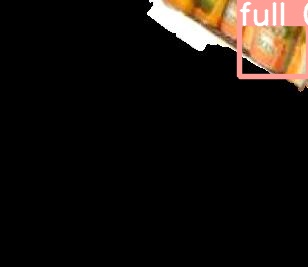

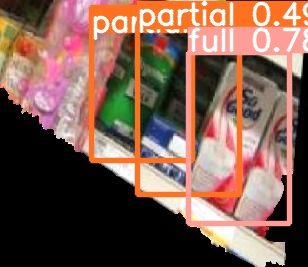

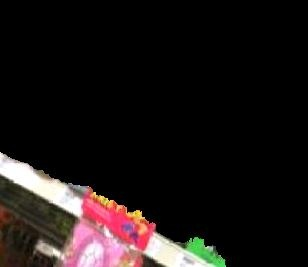

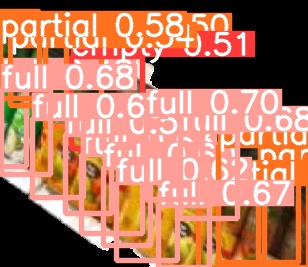

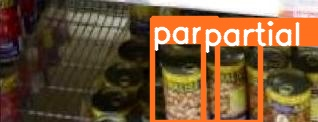

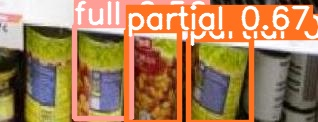

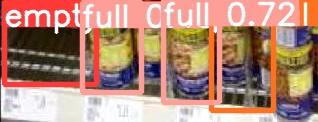

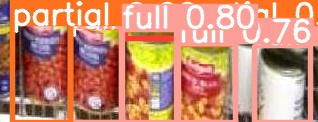

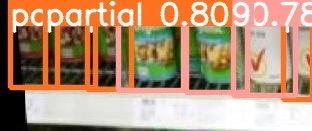

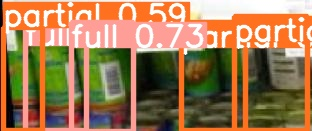

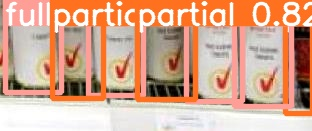

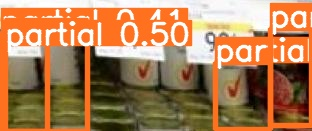

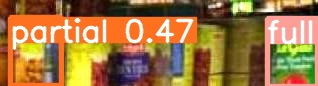

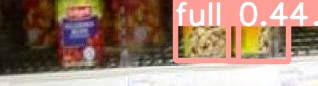

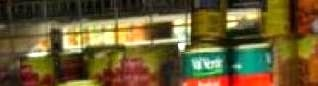

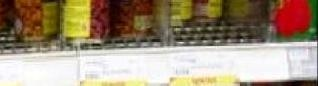

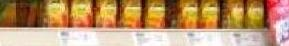

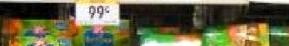

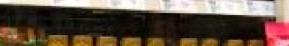

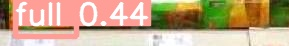

In [10]:
import glob
from IPython.display import Image, display

# Use an absolute path to locate the images
for imageName in glob.glob('/content/drive/MyDrive/yolov5/runs/detect/exp15/*.jpg')[:20]: #assuming JPG
    display(Image(filename=imageName))

YOLOv5 🚀 v7.0-72-g064365d8 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
YOLOv5l summary: 182 layers, 7251912 parameters, 0 gradients
Adding AutoShape... 


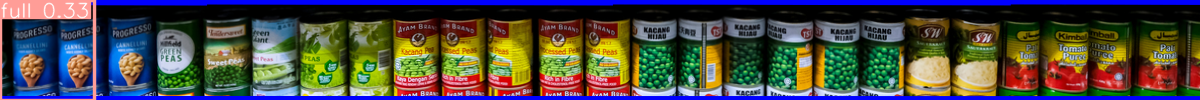

In [ ]:
import torch

# Define the confidence threshold
confidence_threshold = 0.3  # Adjust this to the desired threshold

# Load the YOLOv5 model
model = torch.hub.load('/content/drive/MyDrive/yolov5', 'custom',
                       path='/content/drive/MyDrive/yolov5/runs/train/yolov5s_results3/weights/best.pt',
                       source='local')

# Run inference on a single image
results = model('/content/drive/MyDrive/yolov5/shelves/output/shelf_segment_4.png')

# Filter results to only include detections with confidence greater than the threshold
filtered_results = results.xyxy[0][results.xyxy[0][:, 4] > confidence_threshold]

# Update results with filtered detections
results.xyxy[0] = filtered_results

# Show the image with bounding boxes, only if there are detections above the threshold
if len(filtered_results) > 0:
    results.show()
else:
    print("No detections with confidence above the threshold.")


https://ieeexplore.ieee.org/document/9773108


Hyperparameters

https://mullenba.medium.com/yolov5-hyperparameters-explained-94c61955a9b8

In [ ]:
!git clone https://github.com/ultralytics/ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 24842, done.
remote: Counting objects: 100% (289/289), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 24842 (delta 159), reused 186 (delta 98), pack-reused 24553
Receiving objects: 100% (24842/24842), 14.71 MiB | 15.54 MiB/s, done.
Resolving deltas: 100% (17491/17491), done.
Updating files: 100% (593/593), done.


In [ ]:

%cd drive/MyDrive/yolov5
%ls

/content/drive/MyDrive/yolov5
benchmarks.py    export.py     README.zh-CN.md             ShelfGapDetection_Racks-4/  val.py
CITATION.cff     hubconf.py    requirements.txt            shelves/                    yolov5s.pt
classify/        LICENSE       runs/                       train.py
CONTRIBUTING.md  models/       segment/                    tutorial.ipynb
data/            __pycache__/  setup.cfg                   ultralytics/
detect.py        README.md     ShelfGapDetection_Racks-2/  utils/


Hyperparameter Evolution using the genetic algorithm.

189 generations are handled. 30 parameters for 10 epochs each - equal to 300 iterations. The iteration had been cancelled at the 189th loop. Handled in single gpu.

In [ ]:
!python train.py --epochs 10 --data ShelfGapDetection_Racks-4/data.yaml --weights yolov5s.pt --cache --evolve


Streaming output truncated to the last 5000 lines.
      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
        3/9      3.38G    0.05863     0.1192    0.02395         74        640: 100% 137/137 [00:17<00:00,  7.93it/s]

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
        4/9      3.38G    0.05222     0.1161    0.01891         93        640: 100% 137/137 [00:16<00:00,  8.07it/s]

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
        5/9      3.38G    0.04959     0.1145    0.01635        106        640: 100% 137/137 [00:16<00:00,  8.11it/s]

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
        6/9      3.38G    0.04686      0.112    0.01436         54        640: 100% 137/137 [00:16<00:00,  8.11it/s]

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
        7/9      3.38G    0.04539     0.1097    0.01305         57        640: 100% 137

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/yolov5

/content/drive/MyDrive/yolov5


In [ ]:
!python train.py --img 640 --batch 32 --epochs 30 --data ShelfGapDetection_Racks-4/data.yaml --cfg models/yolov5l.yaml --weights '' --name yolov5l_results_evolvedHyp  --cache  ram --hyp ./runs/evolve/exp2/hyp_evolve.yaml

2024-05-01 16:38:52.970744: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 16:38:52.970795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 16:38:52.972725: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 16:38:54.033802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=models/yolov5l.yaml, data=ShelfGapDetection_Racks-4/data.yaml, hyp=./runs/evolve/exp2/hyp_evolve.yaml, epochs=30, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots

In [ ]:
!python detect.py --weights runs/train/yolov5l_results_evolvedHyp/weights/best.pt --img 640 --conf 0.5 --source ShelfGapDetection_Racks-4/test/images/

detect: weights=['runs/train/yolov5l_results_evolvedHyp/weights/best.pt'], source=ShelfGapDetection_Racks-4/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
YOLOv5l summary: 267 layers, 46119048 parameters, 0 gradients, 107.7 GFLOPs
image 1/156 /content/drive/MyDrive/yolov5/ShelfGapDetection_Racks-4/test/images/100_png.rf.52e0e6b60a9fe9ff9c9239c28da03785.jpg: 576x640 3 fulls, 103.0ms
image 2/156 /content/drive/MyDrive/yolov5/ShelfGapDetection_Racks-4/test/images/100_png.rf.a728f2de57d227293152dd3e291d631d.jpg: 576x640 1 empty, 

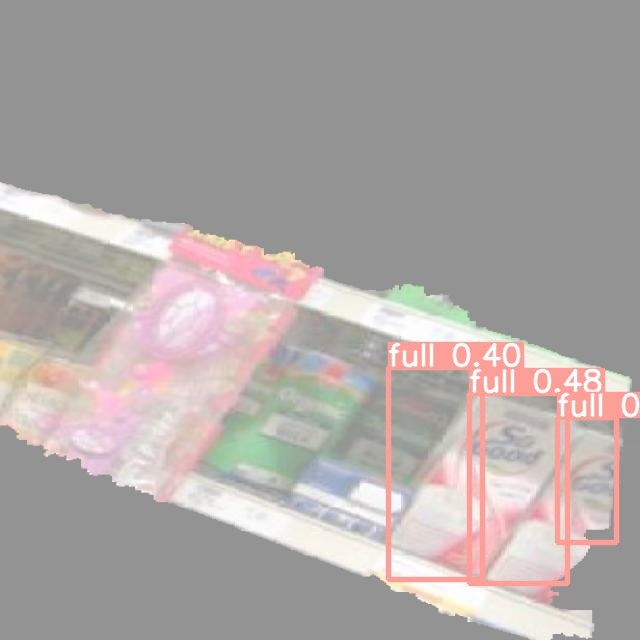

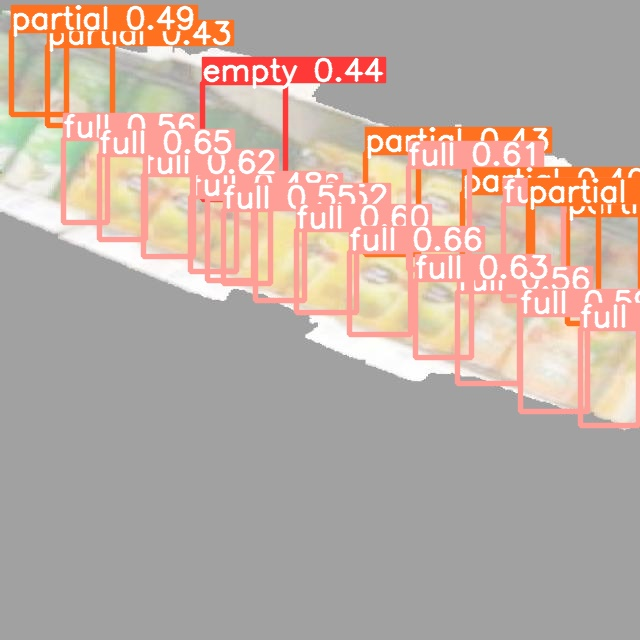

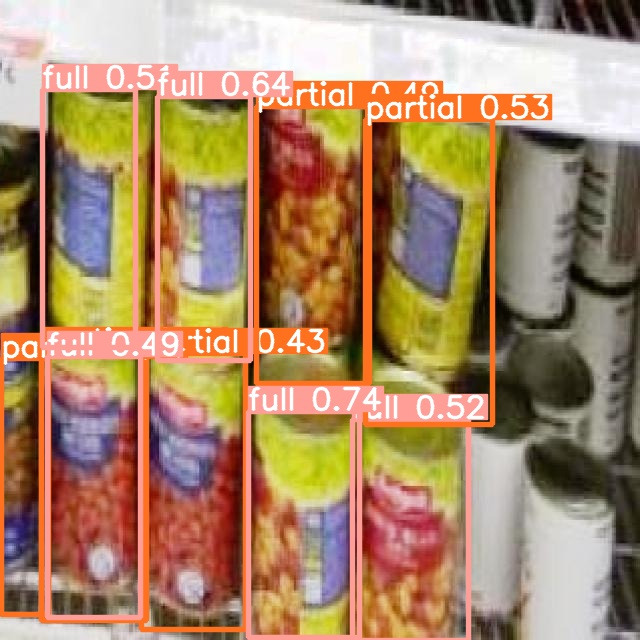

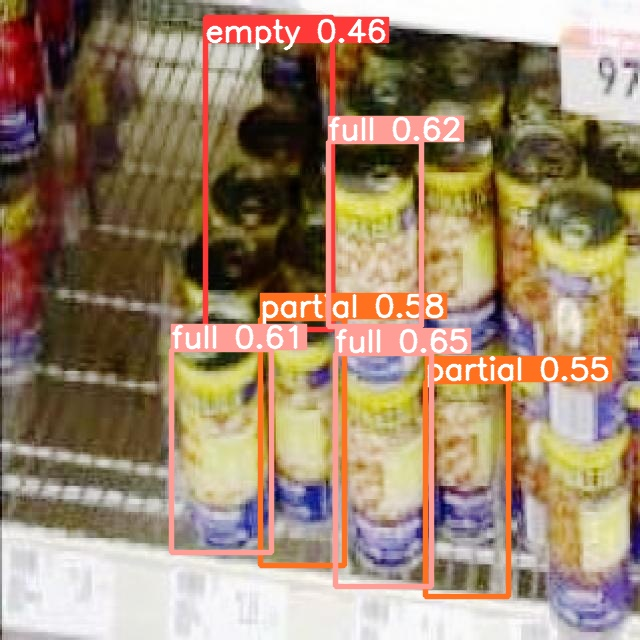

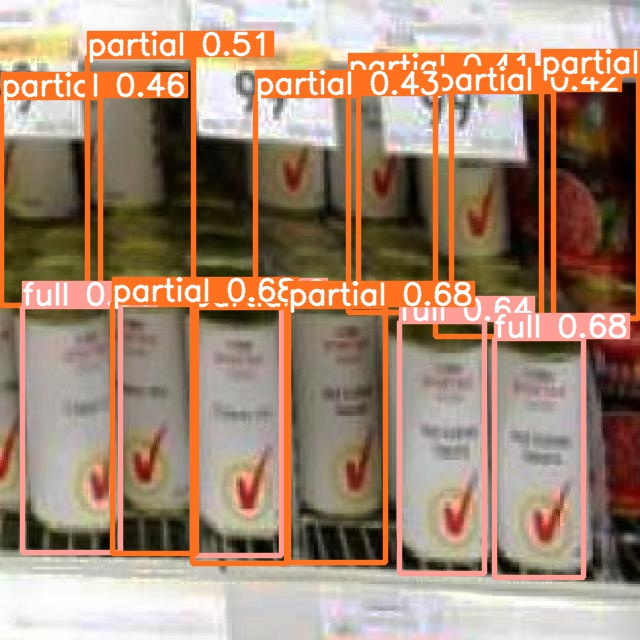

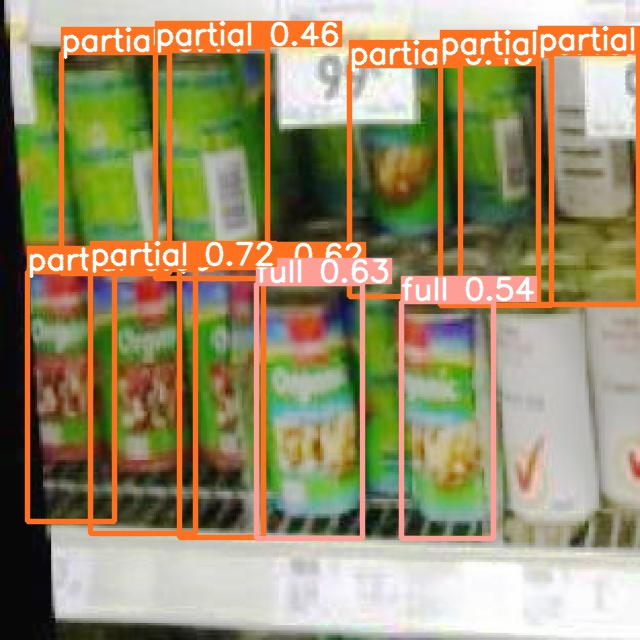

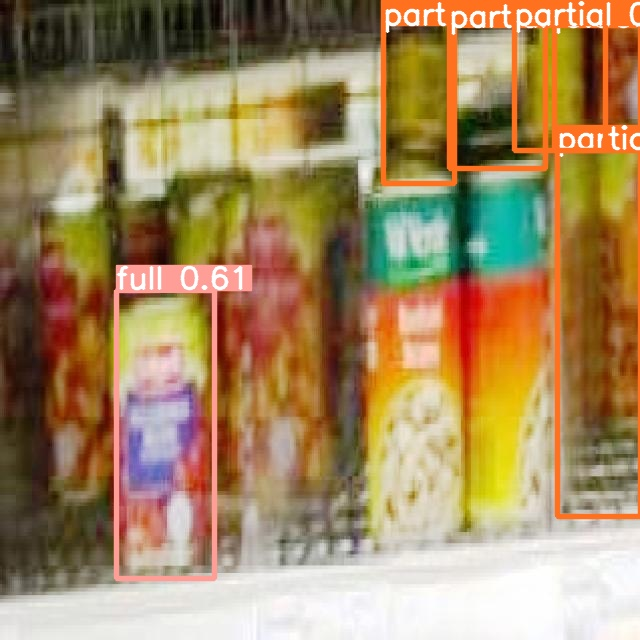

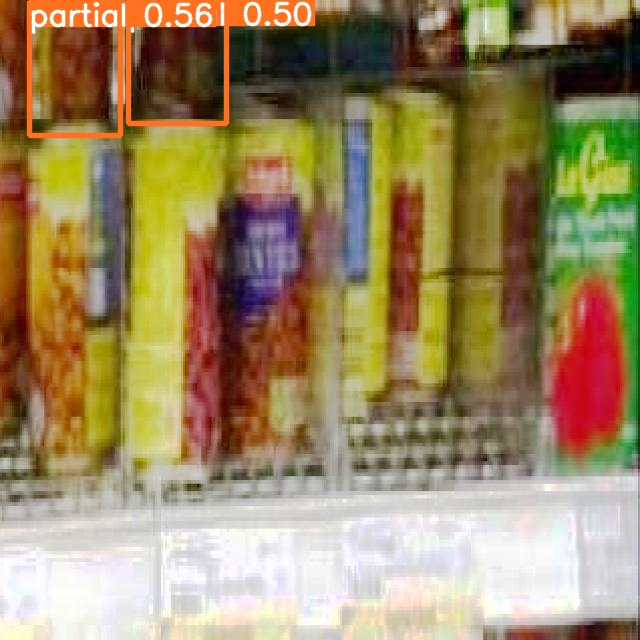

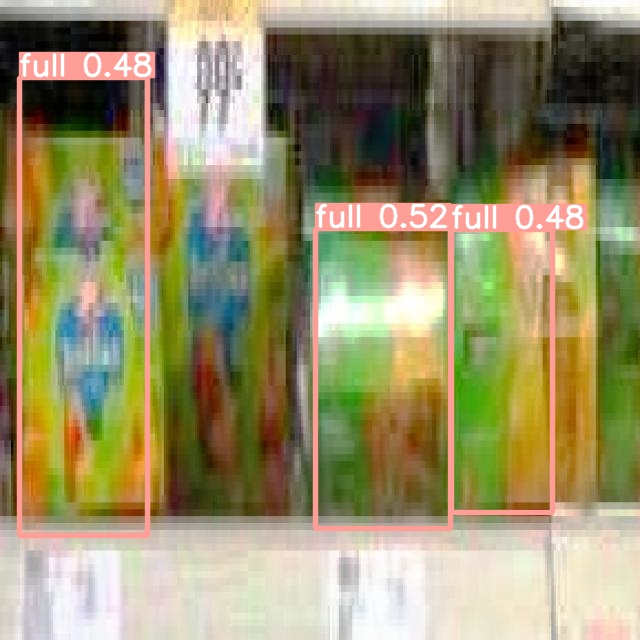

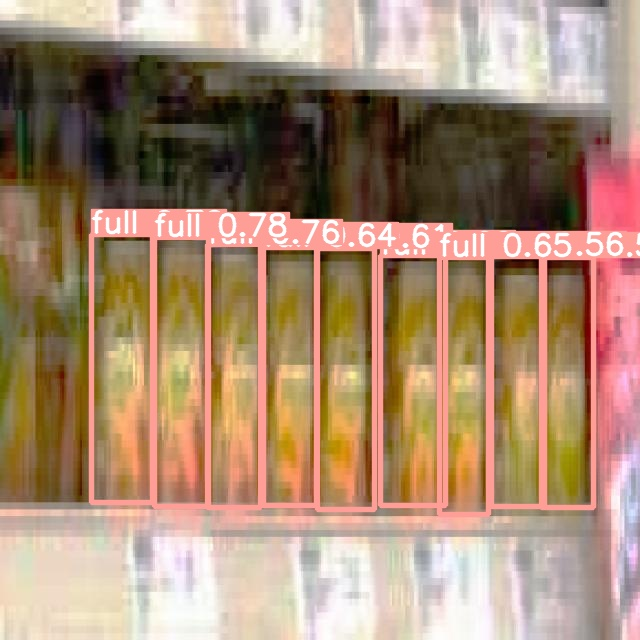

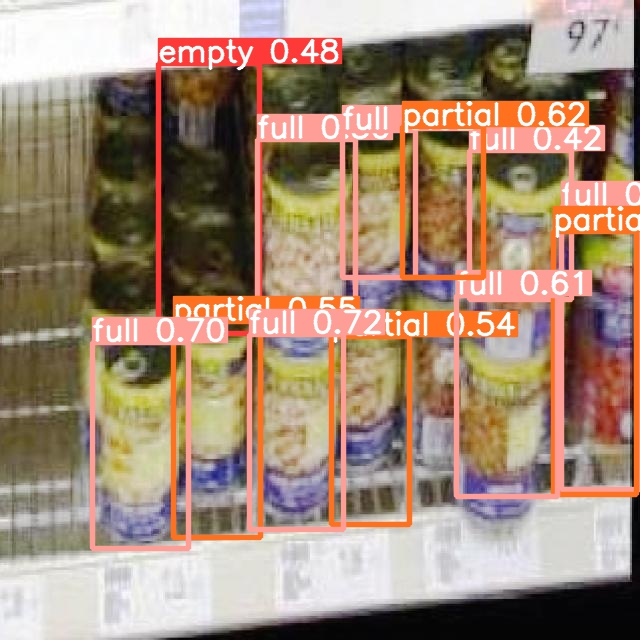

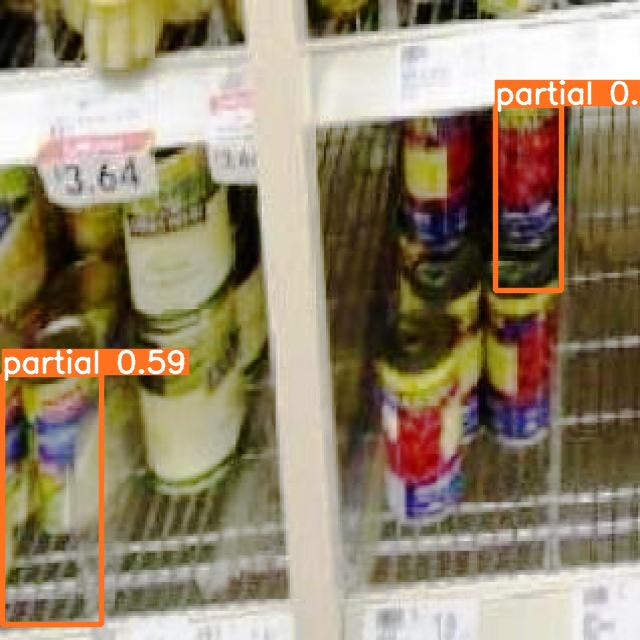

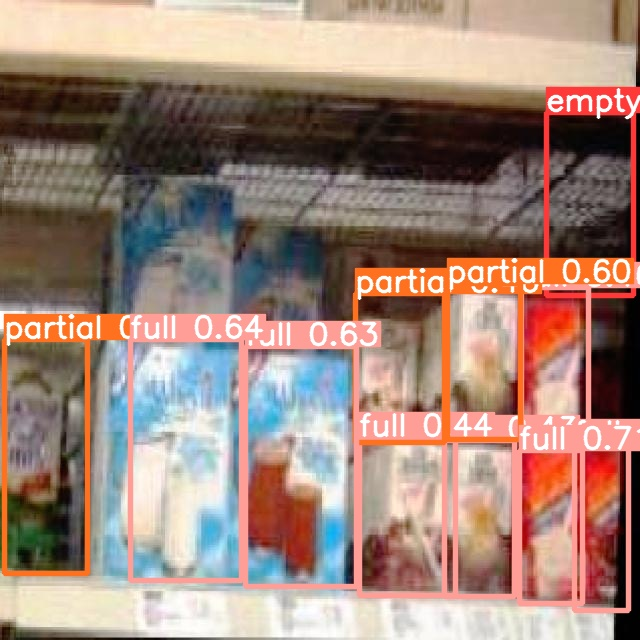

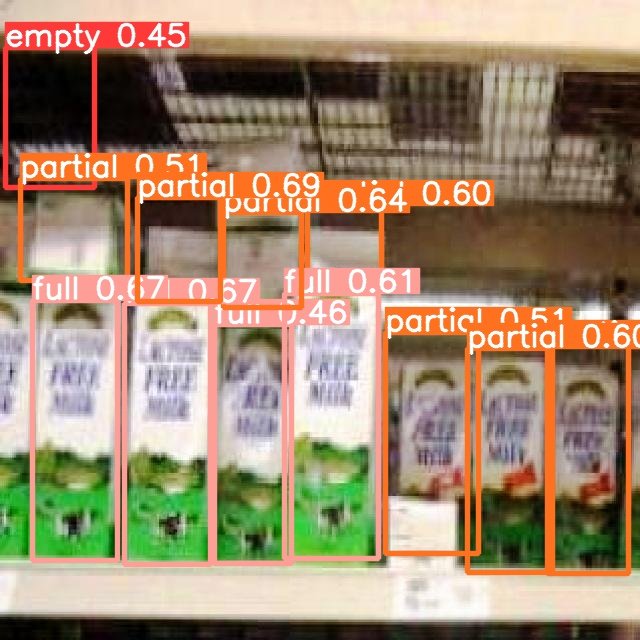

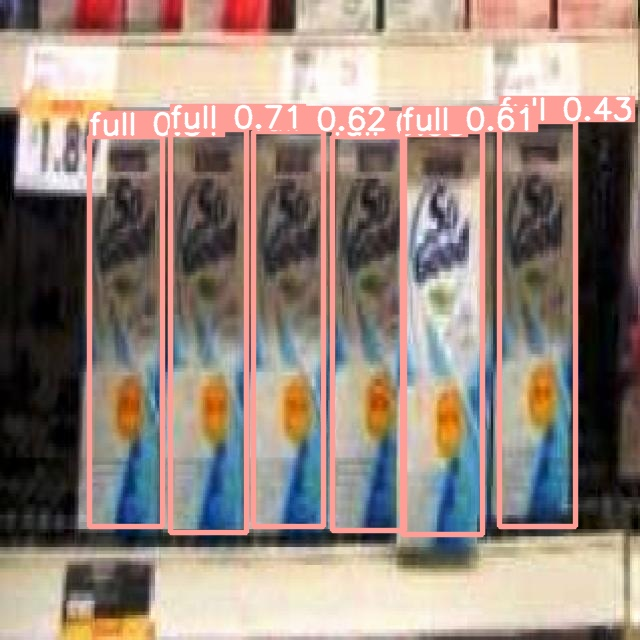

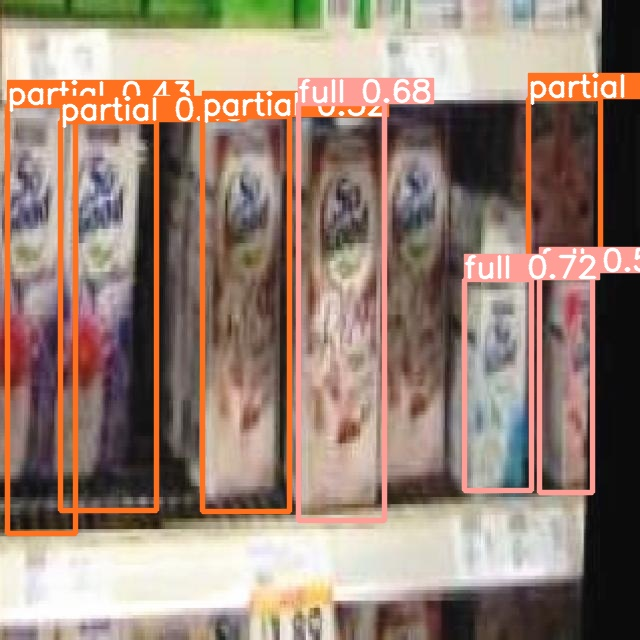

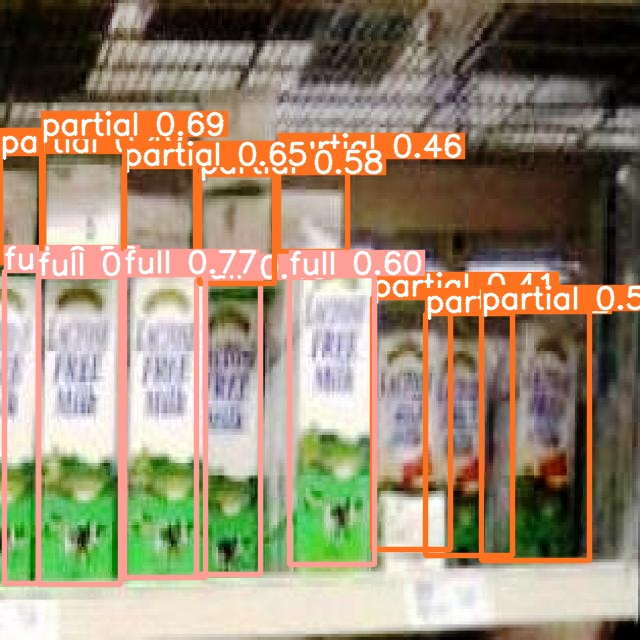

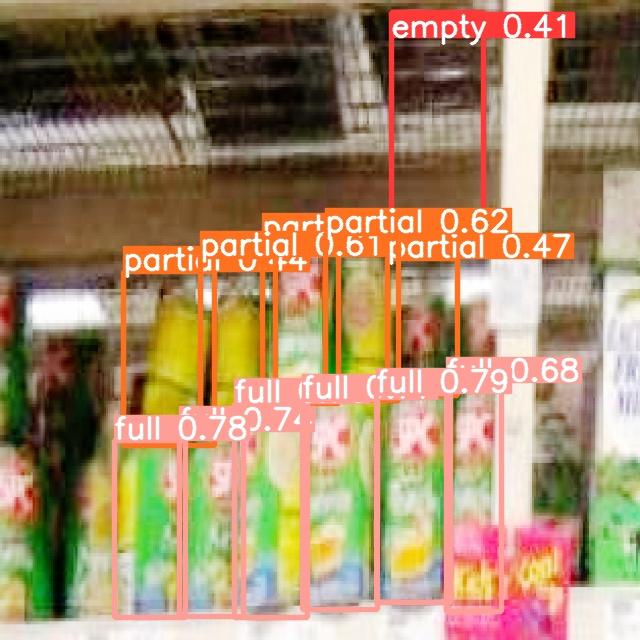

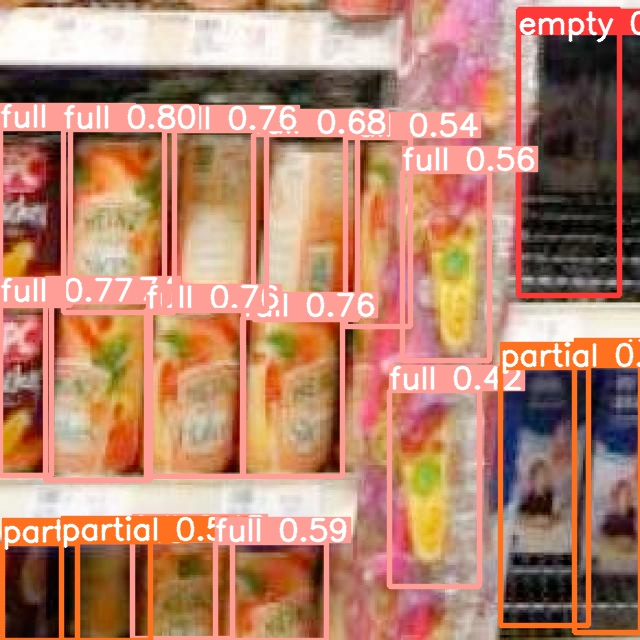

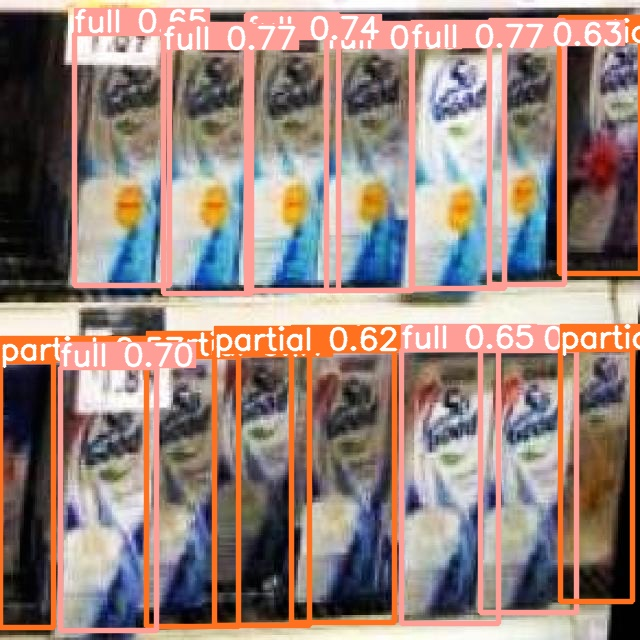

In [25]:
import glob
from IPython.display import Image, display

# Use an absolute path to locate the images
for imageName in glob.glob('/content/drive/MyDrive/yolov5/runs/detect/exp2/*.jpg')[:20]: #assuming JPG
    display(Image(filename=imageName))

requirements: YOLOv5 requirements "gitpython" "ipython" "torch>=1.7.0" "torchvision>=0.8.1" not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cuso

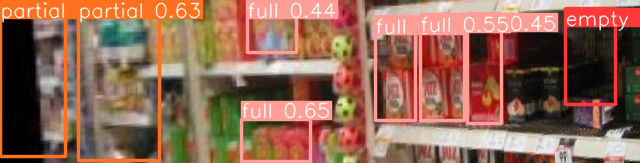

In [6]:
import torch

# Define the confidence threshold
# Load the YOLOv5 model
model = torch.hub.load('/content/drive/MyDrive/yolov5', 'custom',
                       path='/content/drive/MyDrive/yolov5/runs/train/yolov5l_results_evolvedHyp/weights/best.pt',
                       source='local')
model.conf = 0.3
model.iou = 0.02
model.agnostic= False
# Run inference on a single image
im= '/content/drive/MyDrive/yolov5/shelves/output/test10/shelf_segment_1.png'
results = model(im)  # custom inference size


results.show()
